# Analyze Zacros kMC trajectories data for O-Pt(111)

In [ ]:
import numpy as np
from pathlib  import Path
import json
import matplotlib.pyplot as plt
import scm.pyzacros as pz
import zacros_functions as zf

In [101]:
# Time binning parameters
n_bins = 100

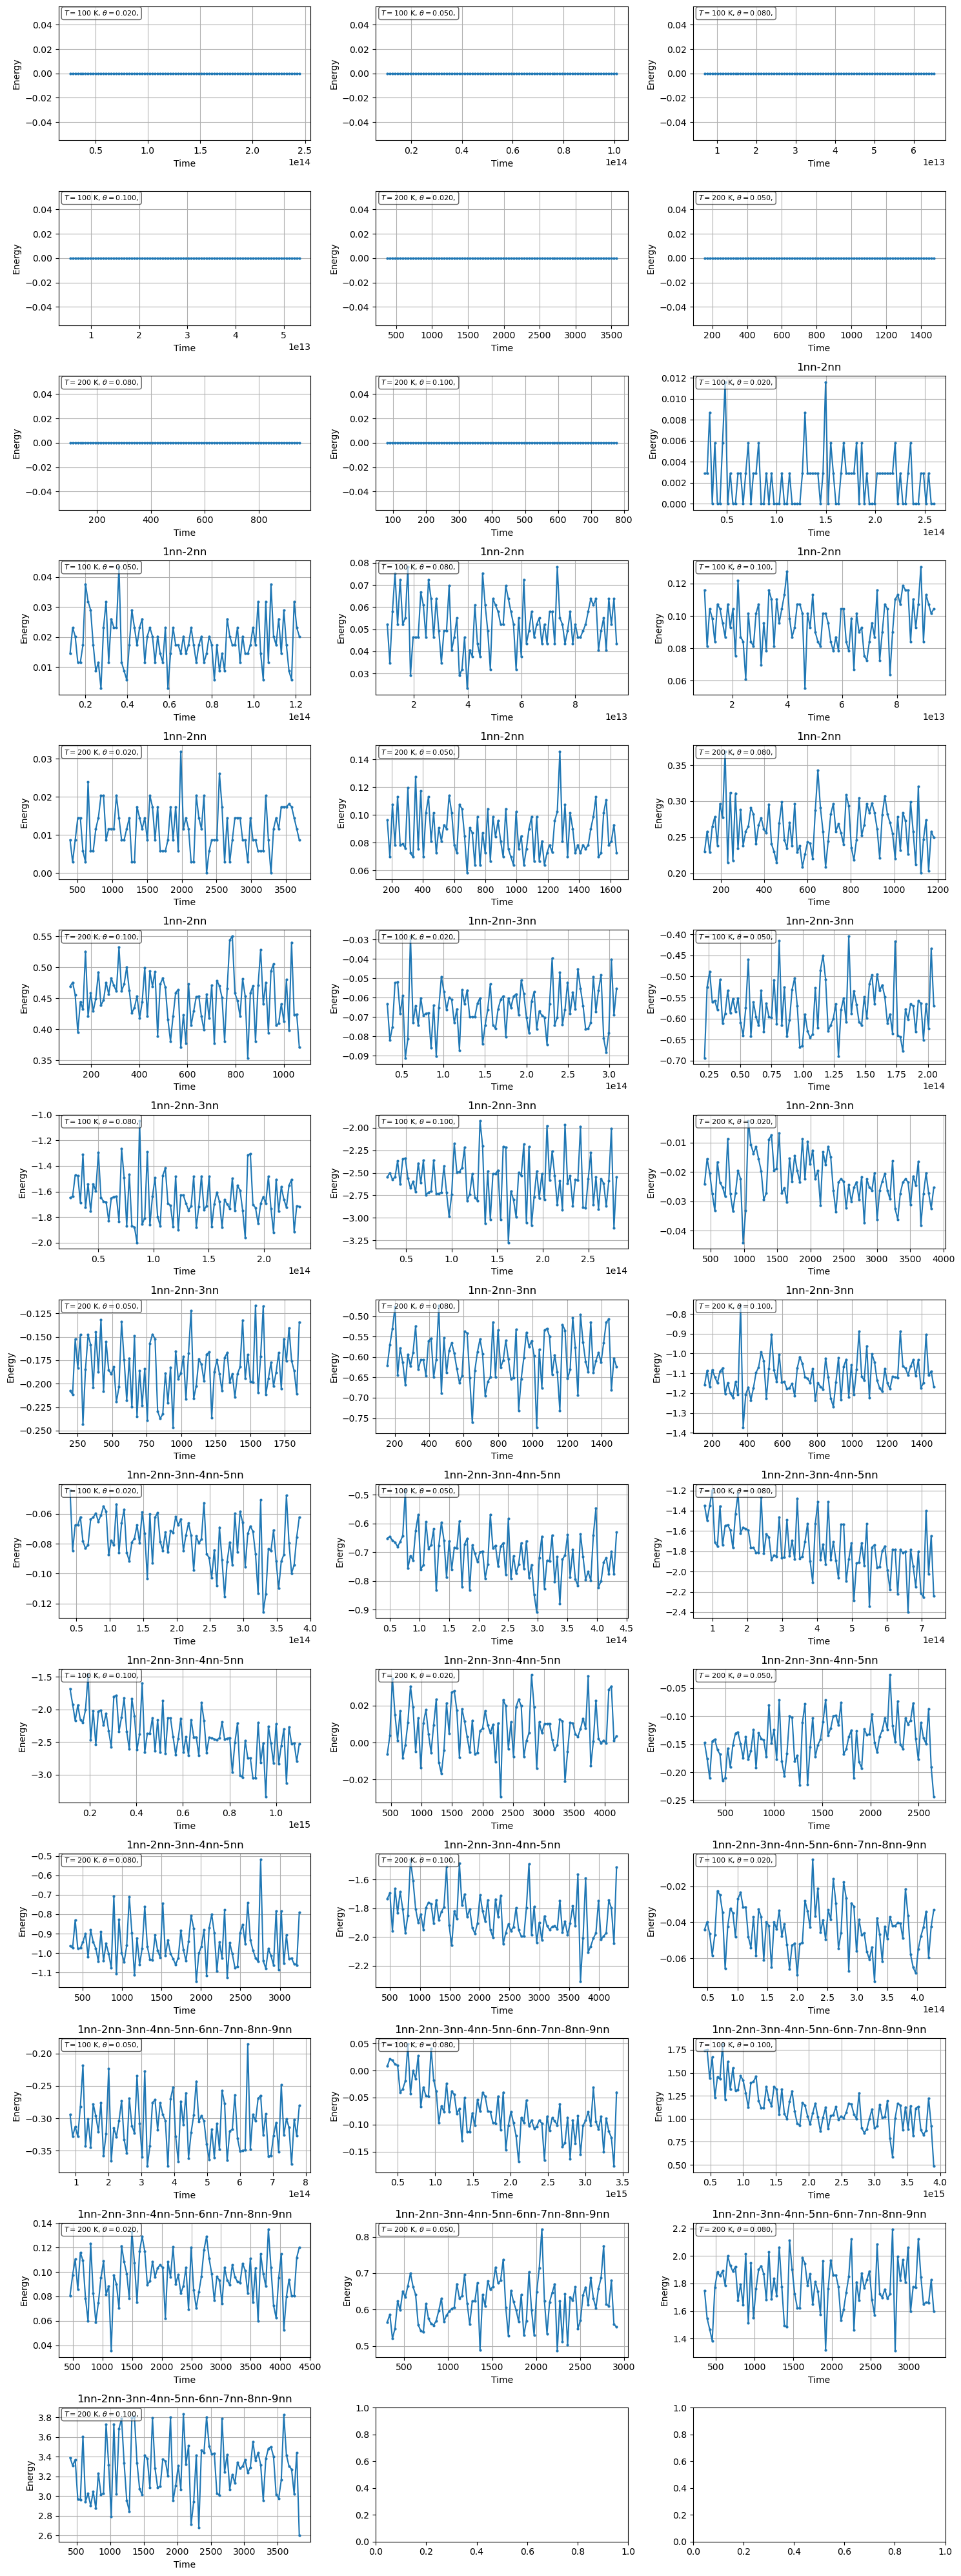

In [116]:
# Set log file
log_file = Path('/home/akandra/O_Pt111/zacros_jobs/jobs.log')
datadir = log_file.parent
# Load json log file
with open(log_file, 'r') as f:
   log_header = f.readline().split()  # Read header
   log_entries = [json.loads(line) for line in f if line.strip()]

# Analyze data
rundirs =[datadir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]

ncols = 3
fig, axes = plt.subplots(int(np.ceil(len(rundirs)/ncols)), ncols, figsize=(15,40))

for ir,rundir in enumerate(rundirs):

   # Get list of trajectories
   traj_files = list(rundir.rglob('history_output.txt'))

   # Get number of configurations and maximum kmc time for all trajectories
   nconfs = []
   end_time = np.inf
   for traj_file in traj_files:
      with open(traj_file) as f:
         for line in f: 
            if 'configuration' in line: 
               confs = int(line.split()[1])
               conf_time = float(line.split()[3])
      end_time = min(end_time, conf_time)
      nconfs.append(confs)

   time_bins   = np.linspace(0, end_time, n_bins+1)
   energy_hist = np.zeros(n_bins)
   for traj_file, confs in zip(traj_files,nconfs):

      time   = np.zeros(confs)
      energy = np.zeros(confs)

      # Get lattice-site coordinates
      try:
         lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
         nsites  = len(lattice)
      except Exception:
         raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
      
      # Get adsorbate positions
      counter = 0
      with open(traj_file) as f:
         for line in f:
               if 'configuration' in line:
                  time[counter]   = float(line.split()[3])
                  energy[counter] = float(line.split()[5])
                  counter += 1

      # Create energy histogram with n_bins
      for i in range(confs):
         bin_index = np.digitize(time[i], time_bins,right=False) - 1
         if bin_index < confs: energy_hist[bin_index] += energy[i]


   # Plot energy as function of time using subplots
   time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
   ax = axes[ir//ncols, ir%ncols]
   ax.plot(time_bin_centers[10:], energy_hist[10:]/len(nconfs), marker='o', linestyle='-', markersize=2)
   ax.set_xlabel('Time')
   ax.set_ylabel('Energy')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

plt.tight_layout()
plt.show()


In [ ]:
if len(traj_zacros_list) > 0: 
    # Zacros
    # Get number of configurations
    nconfs = 0
    with open(traj_zacros_list[0]) as f:
        for line in f:
            if 'configuration' in line:
                nconfs = int(line.split()[1])

    data = np.zeros((nconfs,3))
    start = time.time()
    for itr,tr in enumerate(traj_zacros_list):

        print(f'\rWorking with zacros data...{100*itr/len(traj_zacros_list):.0f}%',end="",flush=True)

        # Get lattice-site coordinates
        lattice = np.loadtxt(tr.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
        ncells = len(lattice)

        # Get adsorbate positions
        i = 0
        with open(tr) as f:
            for line in f:
                if 'configuration' in line:
                    data[i,0] = float(line.split()[3])
                    for j in range(ncells):
                        if int(f.readline().split()[2])>0:
                            data[i,1:3] = lattice[j]
                    i += 1

        # Save positions
        output_fname = out_dir / f'x_{tr.parent.name:>06}.dat'
        np.savetxt(output_fname, data, header=f'{'time(s)':10} {'x(Ang)':10} {'y(Ang)':10}')

    end = time.time()
    print(f' done in {end-start:.2f} seconds')

else: 
    # kmc_tian

    # Lattice vectors for fcc(111)
    lvecs = np.array([ [1, 0], [np.cos(np.pi/3), -np.sin(np.pi/3)]])

    traj_tian_list = list(in_dir.glob('*_*.confs'))

    # Get number of configurations
    nconfs = 0
    with open(traj_tian_list[0]) as f:
        for line in f:
            if 'time' in line:
                nconfs += 1

    data = np.zeros((nconfs,3))
    start = time.time()
    for itr,tr in enumerate(traj_tian_list):
        print(f'\rWorking with kmc_tian data...{100*itr/len(traj_tian_list):.0f}%',end="",flush=True)

        # Get adsorbate positions
        i = 0
        with open(tr) as f:
            for line in f:
                if 'time' in line:
                    data[i,0] = float(line.split()[1])
                    f.readline()
                    pos = np.array(f.readline().split()[1:3],dtype=int)
                    data[i,1:3] = np.dot(pos,lvecs)
                    i += 1

        # Save positions
        output_fname = out_dir / f'x_{tr.stem.split('_')[-1]}.dat'
        np.savetxt(output_fname, data, header=f'{'time(s)':10} {'x(Ang)':10} {'y(Ang)':10}')

    end = time.time()
    print(f' done in {end-start:.2f} seconds')



In [2]:
def get_lattice_xy(lattice_input_file):
    """
    Produces cartesian coordinates of lattice sites 
    Parameters
    ----------
    lattice_input_file : str or Path
        Path to the Zacros lattice input file.
    Returns
    -------
    coords : np.array
        (List of) Array(s) of cartesian coordinates of lattice sites.
    """

    # Read lattice input file

    try:
        with open(lattice_input_file, 'r') as f:
            content = [line for line in f.readlines() if (line.strip() and not line.startswith('#'))]
    except FileNotFoundError:
        raise FileNotFoundError(f"Lattice input file '{lattice_input_file}' not found.")
    finally:
        content = [line.split('#')[0] for line in content]

    for i,line in enumerate(content):
            if 'cell_vectors' in line:
                unit_cell = np.array([ [float(x) for x in content[i+1].split()],
                              [float(x) for x in content[i+2].split()] ])
            if 'repeat_cell' in line:
                repeat_cell = np.array([ int(x) for x in line.split()[1:3] ])
            if 'n_site_types' in line:
                n_site_types = int(line.split()[1])
            if 'n_cell_sites' in line:
                n_cell_sites = int(line.split()[1])
            if 'site_types' in line:
                site_types_names = line.split()[1:]
            if 'site_coordinates' in line:
                site_coordinates = []
                for j in range(n_cell_sites):
                    site_coordinates.append([float(x) for x in content[i+1+j].split()[:2]])
                site_uc_coordinates = np.array(site_coordinates) @ unit_cell


    site_coordinates = []
    site_types = []
    for i in range(repeat_cell[0]):
        for j in range(repeat_cell[1]):
            shift = np.array([i,j]) @ unit_cell
            for coords,st in zip(site_uc_coordinates , site_types_names):
                site_types.append(st)
                site_coordinates.append(coords + shift)
                site_types.append(st)

    v1 = repeat_cell[0] * unit_cell[0]
    v2 = repeat_cell[1] * unit_cell[1]

    return np.array(site_coordinates),v1,v2



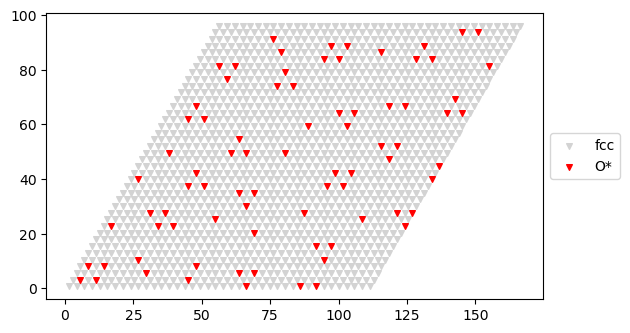

In [12]:
zf.lattice_plot(Path.cwd() /"zacros_run_0050_upto9nn_0070/lattice_input.dat", idx=None, show_axes=True, pause=0.,close=False)

In [55]:
def rdf(confs, coverage, v1, v2, r_max=None, dr=0.1, g_lat=None, lattice_constant=None, ax=None, plot=True):
  """
  Compute 2D radial distribution function g(r) with periodic boundary conditions.

  Parameters
  ----------
  confs : list of (N,2) array_like
      Cartesian coordinates of points.
  v1, v2 : array_like, shape (2,)
      Box vectors spanning the periodic cell.
  r_max : float or None
      Maximum radius to compute g(r). If None use min(box lengths, box diagonal)/2.
  dr : float
      Bin width.

  Returns
  -------
  dist : (M,) array
       Bin midpoints.
  counts/normalization : (M,) array
      Radial distribution function values.
  counts : (M,) array
      Number of unique pairs in each radial bin (unordered pairs).
  edges : (M+1,) array
      Bin edges.
  """
    
  # choose r_max if not provided
  if r_max is None:
      l1 = np.linalg.norm(v1)
      l2 = np.linalg.norm(v2)
      l3 = np.linalg.norm(v1 + v2)
      r_max = min(l1, l2, l3) / 2.0

  cell_matrix = np.vstack([v1, v2]).T
  cell_matrix_inv = np.linalg.inv(cell_matrix)

  nbins = int(np.ceil(r_max / dr))
  edges = np.linspace(0.0, r_max, nbins + 1)
  g = np.zeros(nbins, dtype=int)
  for conf in confs:  
    counts = np.zeros(nbins, dtype=int)
    for i1, r1 in enumerate(conf[:-1]):
      for r2 in conf[i1+1:]:
          r = r2 - r1
          # apply PBC
          frac_r = cell_matrix_inv @ r
          r = cell_matrix @ (frac_r - np.rint(frac_r))
          d = np.linalg.norm(r)
          if (d>0) and (d<=r_max): counts[int(d/dr)] += 1
    # Get 2D lattice ideal gas normalization factor 
    if g_lat is not None: 
      counts_n = np.zeros_like(counts, dtype=float)
      np.divide(counts, g_lat, out=counts_n, where=g_lat!=0)
      g = g + counts_n / len(conf) / coverage  # normalize by coverage
    else:
      g = g + counts / len(conf) / coverage  # normalize by coverage

  dist = 0.5 * (edges[:-1] + edges[1:])

  # Normalization by number of configurations 
  # factor of 2 for unordered pairs
  g = 2*g / len(confs)

  # plotting

  if ax is None:
      fig, ax = plt.subplots()
  if lattice_constant is None:
    ax.set_xlabel(r'$r (\mathrm{\AA})$')
    lattice_constant = 1
  else:
    ax.set_xlabel(r'$r / a_0$')
  ax.set_ylabel(r'g(r)')
  ax.plot(dist/lattice_constant, g, marker='o',color='k')
  #ax.set_ylim(bottom=0)
  ax.grid(True)
  if plot:
      plt.show()
      
  return dist, g #, edges



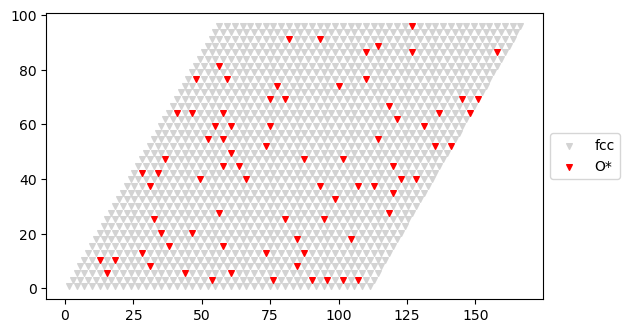

In [78]:
data = Path.cwd() /"zacros_run_0050_upto5nn_0200/lattice_input.dat"
lattice_xy,v1,v2 = get_lattice_xy(data)
ads_coords = zf.get_xy(data)
zf.lattice_plot(data, idx=10)


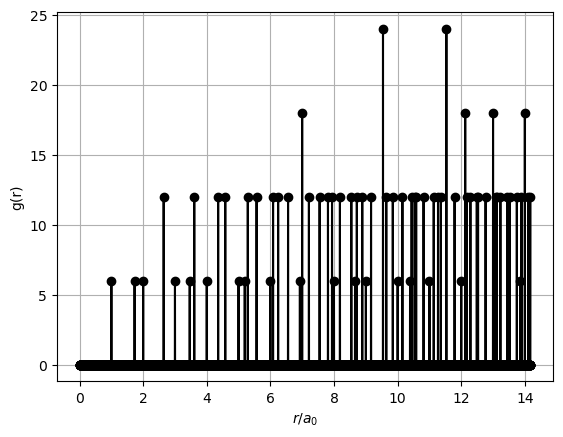

In [64]:
r_lat, g_lat = rdf([lattice_xy],1, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.01)


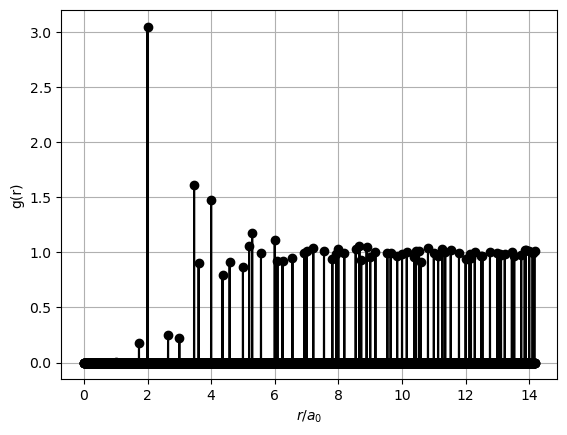

(array([5.0000e-03, 1.5000e-02, 2.5000e-02, ..., 3.9975e+01, 3.9985e+01,
        3.9995e+01], shape=(4000,)),
 array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.01552288], shape=(4000,)))

In [79]:
rdf(ads_coords[49:],0.05, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.01, g_lat=g_lat)

In [ ]:

plot_rdf(ads_coords[99:], v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.1, normalize=False)

labels, clusters, sizes = zf.cluster_points_periodic(ads_coords[0], v1, v2, cutoff=2.001*lattice_constant)
zf.plot_cluster_size_distribution(sizes)

res = zf.cluster_circularity_periodic(ads_coords[0], v1, v2, cutoff=2.001*lattice_constant)
print("n clusters:", len(res['clusters']))
zf.plot_cluster_size_and_circularity(res['sizes'], res['circularities'])

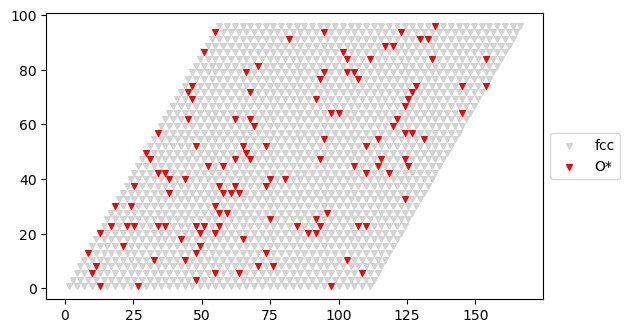

In [43]:
ads_coords,v1,v2 = zf.get_xy(Path.cwd() /"zacros_run_0080_upto0nn_0200/lattice_input.dat")
zf.lattice_plot(Path.cwd() /"zacros_run_0080_upto0nn_0200/lattice_input.dat")

In [45]:
ads_coords[0]

array([12.6951075 , 20.35978815])

In [ ]:

plot_rdf(ads_coords, v1, v2, lattice_constant=lattice_constant, r_max=40.0, dr=0.1)

In [ ]:
n_clusters = []
cluster_counts = []
lat_sizes = [f"{i}x{i}" for i in range(3, 15)]
for lat_size in lat_sizes:

    with open(run_dir / lat_size / 'energlist_output.txt', 'r') as file:
        lines = file.readlines()

    cl_names = lines[0].split()[1:]
    for i, line in enumerate(lines):
        if 'energetics_list_entry' in line: break
        
    n_clusters.append(int(lines[i+1].split()[0]))
    cluster_list = [int(line.split()[0]) for line in lines[i+2: i+2+n_clusters[-1]]]

    cluster_counts.append([cluster_list.count(i) for i in range(1, 11)])


# Extract lattice sizes as numbers (e.g., '3x3' -> 3)
x_vals = [int(size.split('x')[0]) for size in lat_sizes]

for i in range(10):

    plt.figure()
    plt.xlabel('Lattice Size (N)')
    plt.ylabel('# of Clusters / # of adsorbates')
    plt.title(f'# of {cl_names[i]} clusters')
    plt.grid(True)

    y_vals = [cluster_counts[l][i]/nsites**2 for l, nsites in enumerate(x_vals)]
    plt.plot(x_vals, y_vals,'o-')




TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
96/16

6.0